In [687]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn.metrics import mean_squared_error

In [688]:
df = load_data_parquet()
df = data_by_country(df)
df = df.dropna()


c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt", "Country_ISO"]


In [689]:
#df = df.set_index("dt")

In [690]:
df = df[df["Country"]=="Sweden"]

In [691]:
df

,Country,Country_ISO,dt,AverageTemperature
70480640,Sweden,SWE,1743-11-01,3.7652
70480645,Sweden,SWE,1744-04-01,3.3624
70480646,Sweden,SWE,1744-05-01,8.8490
70480647,Sweden,SWE,1744-06-01,13.0116
70480648,Sweden,SWE,1744-07-01,15.6892
...,...,...,...,...
70483873,Sweden,SWE,2013-04-01,3.3374
70483874,Sweden,SWE,2013-05-01,11.9138
70483875,Sweden,SWE,2013-06-01,14.8738
70483876,Sweden,SWE,2013-07-01,17.3276


In [692]:
# Choosing some data to make the arima model with
df = df.loc[(df.dt >= "1950-01-01") & (df.dt <= "2013-08-01")]

df2 = df.loc[(df.dt >= "2000-01-01") & (df.dt <= "2003-12-01")]

In [693]:
df

,Country,Country_ISO,dt,AverageTemperature
70483114,Sweden,SWE,1950-01-01,-4.8920
70483115,Sweden,SWE,1950-02-01,-1.5666
70483116,Sweden,SWE,1950-03-01,1.2306
70483117,Sweden,SWE,1950-04-01,4.9286
70483118,Sweden,SWE,1950-05-01,10.4886
...,...,...,...,...
70483873,Sweden,SWE,2013-04-01,3.3374
70483874,Sweden,SWE,2013-05-01,11.9138
70483875,Sweden,SWE,2013-06-01,14.8738
70483876,Sweden,SWE,2013-07-01,17.3276


In [694]:

df2 = df2[["dt","AverageTemperature"]]
df2 = df2.set_index("dt")

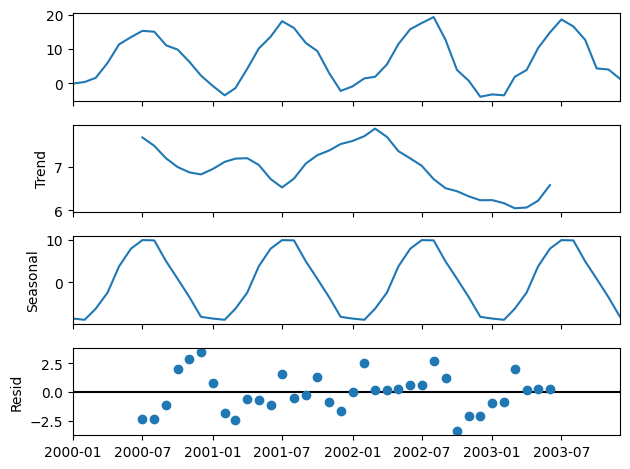

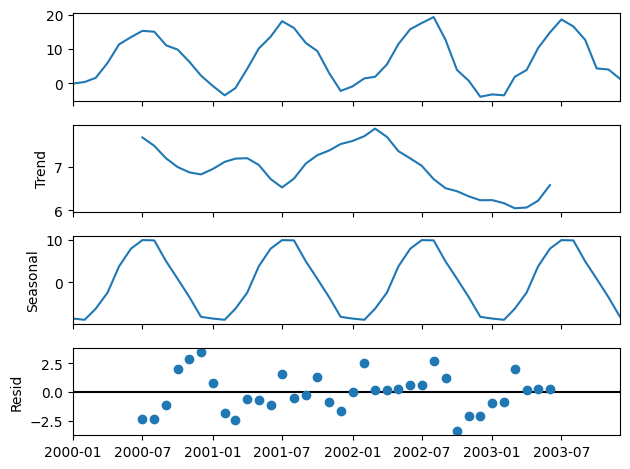

In [695]:

decompose_data = seasonal_decompose(df2, model="additive")
decompose_data.plot()

First we look at the time series...

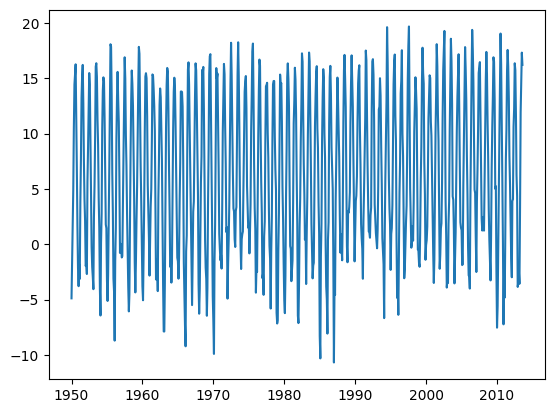

In [696]:
plt.plot(df.dt,df["AverageTemperature"])

Then we have to make the data stationary

Sources: 
https://github.com/jinit24/ARIMA-Model/blob/master/ARIMA.ipynb 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://puneet166.medium.com/time-series-forecasting-how-to-predict-future-data-using-arma-arima-and-sarima-model-8bd20597cc7b

In [697]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(df['AverageTemperature'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  3.5356072384860826e-05


In [698]:
# df_testing = pd.DataFrame(np.log(df.AverageTemperature).diff().diff(12))
# df_testing.dropna()

In [699]:
result = adfuller(df['AverageTemperature'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.896938
p-value: 0.000035
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Reject Ho - Time Series is Stationary


Do we need to shift the data? https://people.duke.edu/~rnau/411arim2.htm

In [700]:
#df["temperatures_shifted"]= df["AverageTemperature"].shift(12)

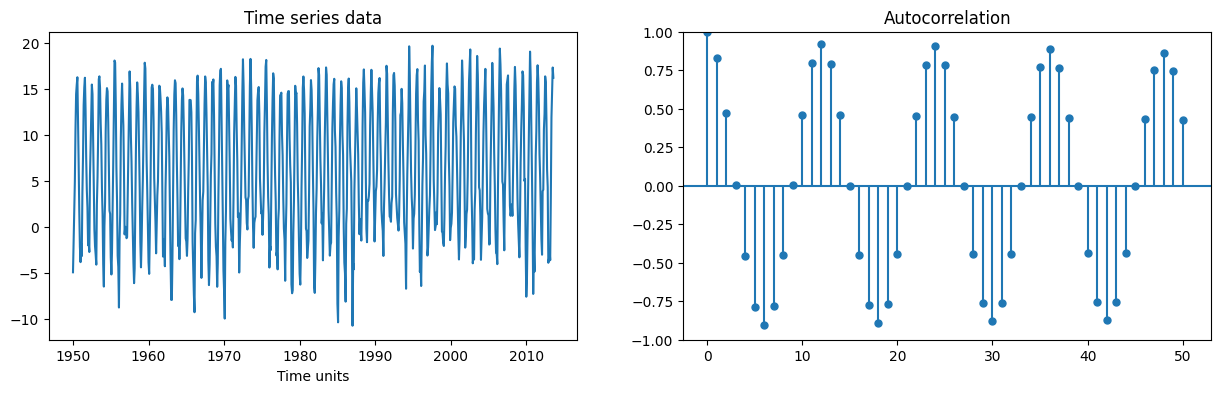

In [701]:

# plot the time series and the ACF
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].plot(df.dt,df["AverageTemperature"])
axes[0].set_title('Time series data')
axes[0].set(xlabel='Time units')
plot_acf(df.AverageTemperature,alpha=1,lags=50,ax=axes[1])
plt.show()

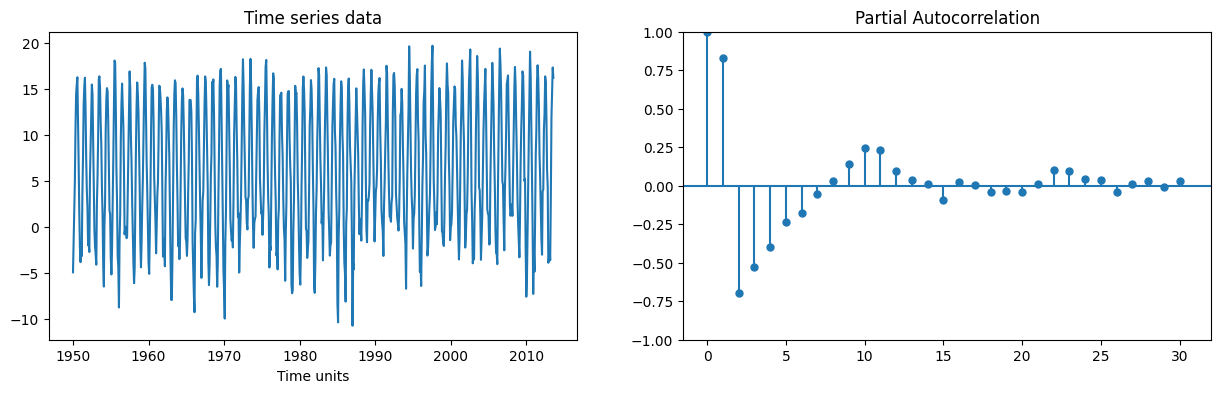

In [702]:
# plot the time series and the ACF
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].plot(df.dt,df["AverageTemperature"])
axes[0].set_title('Time series data')
axes[0].set(xlabel='Time units')
plot_pacf(df.AverageTemperature,alpha=1,lags=30,ax=axes[1])
plt.show()

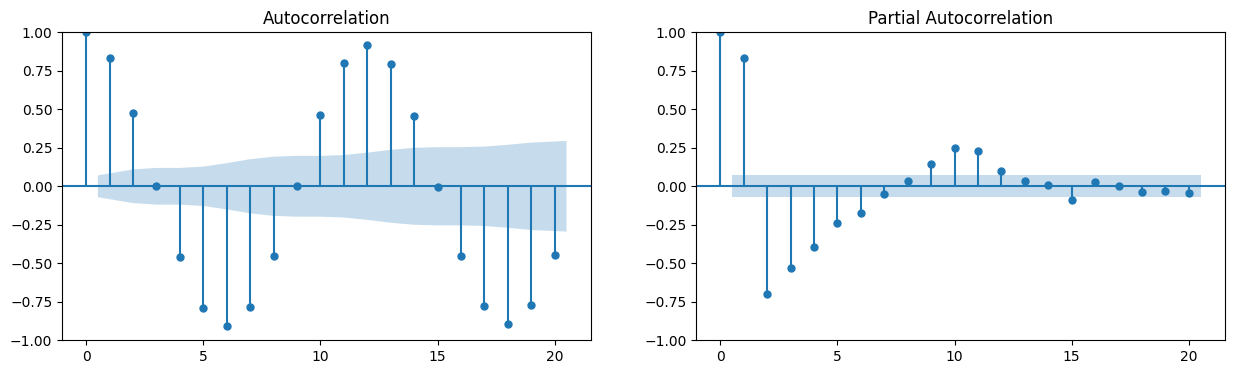

In [703]:
fig, axs = plt.subplots(1,2,figsize=(15,4))
plot_acf(df["AverageTemperature"], lags=20, ax=axs[0])
plot_pacf(df["AverageTemperature"], lags=20, ax=axs[1])
plt.show()

Based on acf, we have 2 lags, and with pacf 5 lags. Therefore, we should test the arima model from 2-5 lags

In [704]:
df.head()

,Country,Country_ISO,dt,AverageTemperature
70483114,Sweden,SWE,1950-01-01,-4.8920
70483115,Sweden,SWE,1950-02-01,-1.5666
70483116,Sweden,SWE,1950-03-01,1.2306
70483117,Sweden,SWE,1950-04-01,4.9286
70483118,Sweden,SWE,1950-05-01,10.4886


In [705]:
df.dropna(inplace=True)

C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [706]:
df.head()

,Country,Country_ISO,dt,AverageTemperature
70483114,Sweden,SWE,1950-01-01,-4.8920
70483115,Sweden,SWE,1950-02-01,-1.5666
70483116,Sweden,SWE,1950-03-01,1.2306
70483117,Sweden,SWE,1950-04-01,4.9286
70483118,Sweden,SWE,1950-05-01,10.4886


In [707]:
# Dropping values we dont need
#df_testing = df.copy()
df_testing = df2.copy()
df_testing = df_testing[["AverageTemperature"]]
df_testing

,AverageTemperature
dt,
2000-01-01,-0.0738
2000-02-01,0.3756
2000-03-01,1.5902
2000-04-01,5.9578
2000-05-01,11.3468
2000-06-01,13.4314
2000-07-01,15.2748
2000-08-01,15.0294
2000-09-01,11.0626


In [708]:
df_testing2 = df_testing.copy()
#df_testing2 = df_testing2[["AverageTemperature"]]
#df_testing2
#average_temp = df_testing2["AverageTemperature"]
# df_testing2["Constant"] = 1
# df_testing2

In [709]:
for i in range(1,5+1):
    df_testing2['Shifted_values_%d' % i ] = df_testing2['AverageTemperature'].shift(i)

In [710]:
#Splitting data into training and testing sets
train_size = int(df_testing2.shape[0]*0.8)

df_train = pd.DataFrame(df_testing2[0:train_size])
df_test = pd.DataFrame(df_testing2[train_size:])

# # df_train.shape[0] + df_test.shape[0] == df_testing.shape[0]
# df_train = pd.DataFrame(df_testing[0:train_size])

# df_test = pd.DataFrame(df_testing[train_size:df.shape[0]])
df_train

,AverageTemperature,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5
dt,,,,,,
2000-01-01,-0.0738,NaN,NaN,NaN,NaN,NaN
2000-02-01,0.3756,-0.0738,NaN,NaN,NaN,NaN
2000-03-01,1.5902,0.3756,-0.0738,NaN,NaN,NaN
2000-04-01,5.9578,1.5902,0.3756,-0.0738,NaN,NaN
2000-05-01,11.3468,5.9578,1.5902,0.3756,-0.0738,NaN
2000-06-01,13.4314,11.3468,5.9578,1.5902,0.3756,-0.0738
2000-07-01,15.2748,13.4314,11.3468,5.9578,1.5902,0.3756
2000-08-01,15.0294,15.2748,13.4314,11.3468,5.9578,1.5902
2000-09-01,11.0626,15.0294,15.2748,13.4314,11.3468,5.9578


In [711]:
  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,5)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

In [712]:
X_train.shape

(33, 5)

In [713]:
y_train.shape

(33, 1)

In [714]:
 X_train_with_intercept = np.column_stack((np.ones(X_train.shape[0]), X_train))


In [715]:
X_train_with_intercept

array([[ 1.    , 11.3468,  5.9578,  1.5902,  0.3756, -0.0738],
       [ 1.    , 13.4314, 11.3468,  5.9578,  1.5902,  0.3756],
       [ 1.    , 15.2748, 13.4314, 11.3468,  5.9578,  1.5902],
       [ 1.    , 15.0294, 15.2748, 13.4314, 11.3468,  5.9578],
       [ 1.    , 11.0626, 15.0294, 15.2748, 13.4314, 11.3468],
       [ 1.    ,  9.8188, 11.0626, 15.0294, 15.2748, 13.4314],
       [ 1.    ,  6.2276,  9.8188, 11.0626, 15.0294, 15.2748],
       [ 1.    ,  2.2456,  6.2276,  9.8188, 11.0626, 15.0294],
       [ 1.    , -0.7798,  2.2456,  6.2276,  9.8188, 11.0626],
       [ 1.    , -3.5006, -0.7798,  2.2456,  6.2276,  9.8188],
       [ 1.    , -1.397 , -3.5006, -0.7798,  2.2456,  6.2276],
       [ 1.    ,  4.2456, -1.397 , -3.5006, -0.7798,  2.2456],
       [ 1.    , 10.1234,  4.2456, -1.397 , -3.5006, -0.7798],
       [ 1.    , 13.568 , 10.1234,  4.2456, -1.397 , -3.5006],
       [ 1.    , 18.0912, 13.568 , 10.1234,  4.2456, -1.397 ],
       [ 1.    , 16.114 , 18.0912, 13.568 , 10.1234,  4

In [716]:
X_train

array([[11.3468,  5.9578,  1.5902,  0.3756, -0.0738],
       [13.4314, 11.3468,  5.9578,  1.5902,  0.3756],
       [15.2748, 13.4314, 11.3468,  5.9578,  1.5902],
       [15.0294, 15.2748, 13.4314, 11.3468,  5.9578],
       [11.0626, 15.0294, 15.2748, 13.4314, 11.3468],
       [ 9.8188, 11.0626, 15.0294, 15.2748, 13.4314],
       [ 6.2276,  9.8188, 11.0626, 15.0294, 15.2748],
       [ 2.2456,  6.2276,  9.8188, 11.0626, 15.0294],
       [-0.7798,  2.2456,  6.2276,  9.8188, 11.0626],
       [-3.5006, -0.7798,  2.2456,  6.2276,  9.8188],
       [-1.397 , -3.5006, -0.7798,  2.2456,  6.2276],
       [ 4.2456, -1.397 , -3.5006, -0.7798,  2.2456],
       [10.1234,  4.2456, -1.397 , -3.5006, -0.7798],
       [13.568 , 10.1234,  4.2456, -1.397 , -3.5006],
       [18.0912, 13.568 , 10.1234,  4.2456, -1.397 ],
       [16.114 , 18.0912, 13.568 , 10.1234,  4.2456],
       [11.7362, 16.114 , 18.0912, 13.568 , 10.1234],
       [ 9.3938, 11.7362, 16.114 , 18.0912, 13.568 ],
       [ 2.973 ,  9.3938, 11

Now we need to do linear regression on the training data

In [717]:
def ols_linear_regression(X, y):
    """
    Perform Ordinary Least Squares (OLS) Linear Regression.

    Parameters:
    - X (numpy array): Feature matrix of shape (n_samples, n_features).
    - y (numpy array): Target vector of shape (n_samples,).

    Returns:
    - coefficients (numpy array): Coefficients (weights) of the linear model.
    - intercept (float): Intercept (bias) of the linear model.
    """
    # Add a constant (intercept) term to X
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))

    # Calculate coefficients and intercept using the closed-form solution (OLS)
    beta = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y)
    intercept = beta[0]
    coefficients = beta[1:]

    return coefficients, intercept

In [718]:
result = ols_linear_regression(X_train,y_train)
result[1]

array([5.83184263])

How does it compare to the sklearn library?

In [719]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [720]:
print(lr.coef_)
print(lr.intercept_)

[[ 0.82203569 -0.22730319  0.20174936 -0.38954167 -0.22454887]]
[5.83184263]


In [721]:
def predict_ols_linear_regression(X, coefficients, intercept):
    """
    Make predictions using OLS Linear Regression coefficients and intercept.

    Parameters:
    - X (numpy array): Feature matrix of shape (n_samples, n_features).
    - coefficients (numpy array): Coefficients (weights) of the linear model.
    - intercept (float): Intercept (bias) of the linear model.

    Returns:
    - y_pred (numpy array): Predicted values for the input features.
    """
    # Add a constant (intercept) term to X
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))

    # Calculate predictions
    y_pred = X_with_intercept.dot(np.insert(coefficients, 0, intercept))

    return y_pred.reshape(-1,1)

In [722]:
predictions = predict_ols_linear_regression(X_train,result[0],result[1])
# a = predictions.ravel()
# a
# a = predictions.reshape(-1,1)
# a
predictions

array([[13.99617195],
       [14.79196163],
       [14.94659408],
       [11.66644285],
       [ 6.81114423],
       [ 5.45467754],
       [ 1.66666344],
       [ 0.55901084],
       [-0.37212456],
       [-1.04618625],
       [ 3.04867683],
       [ 8.73269372],
       [14.44548921],
       [16.87093436],
       [18.32165123],
       [12.80644289],
       [ 7.90804305],
       [ 4.04323979],
       [-1.83114802],
       [-2.96065149],
       [-0.09857307],
       [ 3.50624103],
       [ 7.07418414],
       [11.06999495],
       [14.00076848],
       [16.24240982],
       [16.42224314],
       [15.18305366],
       [ 6.71059395],
       [-0.3464699 ],
       [-3.36037886],
       [-6.03930215],
       [-0.15369247]])

In [723]:
lr.predict(X_train)

array([[13.99617195],
       [14.79196163],
       [14.94659408],
       [11.66644285],
       [ 6.81114423],
       [ 5.45467754],
       [ 1.66666344],
       [ 0.55901084],
       [-0.37212456],
       [-1.04618625],
       [ 3.04867683],
       [ 8.73269372],
       [14.44548921],
       [16.87093436],
       [18.32165123],
       [12.80644289],
       [ 7.90804305],
       [ 4.04323979],
       [-1.83114802],
       [-2.96065149],
       [-0.09857307],
       [ 3.50624103],
       [ 7.07418414],
       [11.06999495],
       [14.00076848],
       [16.24240982],
       [16.42224314],
       [15.18305366],
       [ 6.71059395],
       [-0.3464699 ],
       [-3.36037886],
       [-6.03930215],
       [-0.15369247]])

In [742]:
def AR(p, df):
    """
    Perform Autoregressive (AR) Time Series Analysis.

    This function prepares and analyzes a time series dataset using an Autoregressive (AR) model.
    It generates lagged features, splits the dataset into training and testing sets, and applies
    linear regression to estimate coefficients for the AR model. It also calculates the Root Mean
    Squared Error (RMSE) and Mean Squared Error (MSE) to assess model performance.

    Parameters:
    - p (int): The order of the Autoregressive (AR) model, representing the number of lagged
      values to consider.
    - df (pandas DataFrame): The input DataFrame containing a 'Date' column and a target variable
      'AverageTemperature'.

    Returns:
    - List: A list containing the following elements:
        1. df_train_2 (pandas DataFrame): Training dataset with lagged features and predictions.
        2. df_test (pandas DataFrame): Testing dataset with lagged features and predictions.
        3. coef (numpy array): Coefficients (weights) of the AR model.
        4. intercept (float): Intercept (bias) of the AR model.
        5. RMSE (float): Root Mean Squared Error of the AR model predictions.
        6. MSE (float): Mean Squared Error of the AR model predictions.
        7. res (pandas DataFrame): Residuals (prediction errors) for the AR model.

    Notes:
    - The function calculates lagged values up to the order 'p' and uses them as features.
    - The dataset is split into training and testing sets, with an 80/20 split ratio.
    - Linear regression is applied to estimate coefficients for the AR model.
    - The RMSE and MSE are computed to evaluate model performance.
    - Residuals are calculated for potential use in a Moving Average (MA) model.

    Example:
    [df_train_2, df_test, coef, intercept, RMSE, MSE, res] = AR(3, df_temperature_data)
    print("The RMSE is:", RMSE)
    print("The order of the AR model is 3.")
    """
    # Copy the input DataFrame to avoid modifying the original data
    df_temp = df.copy()

    # Generate the lagged p terms
    for i in range(1, p + 1):
        df_temp['Shifted_values_%d' % i] = df_temp['AverageTemperature'].shift(i)

    # Determine the size of the training set (80% of the data)
    train_size = (int)(0.8 * df_temp.shape[0])

    # Split the data into training and testing sets
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    # Remove rows with missing values in the training set
    df_train_2 = df_train.dropna()

    # Extract lagged features (X) and target variable (y) for training
    X_train = df_train_2.iloc[:, 1:].values.reshape(-1, p)
    y_train = df_train_2.iloc[:, 0].values.reshape(-1, 1)

    # Apply linear regression to estimate AR model coefficients
    result = ols_linear_regression(X_train, y_train)
    coef = result[0]
    intercept = result[1]

    # Generate predictions for the training set
    df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)

    # Prepare lagged features for the testing set
    X_test = df_test.iloc[:, 1:].values.reshape(-1, p)

    # Generate predictions for the testing set
    df_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef, intercept)

    # Calculate RMSE and MSE to evaluate model performance
    MSE = mean_squared_error(df_test['AverageTemperature'], df_test['Predicted_Values'])
    RMSE = np.sqrt(MSE)

    # Concatenate training and testing data for residuals calculation
    df_ar = pd.concat([df_train_2, df_test])

    # Calculate residuals
    res = pd.DataFrame()
    res['Residuals'] = df_ar['AverageTemperature'] - df_ar['Predicted_Values']

    # Print RMSE and order of the AR model
    print("The RMSE is :", RMSE,", Value of p : ",p)

    return [df_train_2, df_test, coef, intercept, RMSE, MSE, res]

In [743]:

[df_train_2,df_test,coef,intercept,RMSE,MSE,res] = AR(1,df_testing)

The RMSE is: 4.204932891294379
The order of the AR model is 1


C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\3836546262.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)


In [744]:

lags = range(1,2)
all_mse = []
all_rmse = []
for i in range(1,2):
    print(i)
    [df_train_2,df_test,coef,intercept,RMSE,MSE,res] = AR(i,df_testing)
    all_rmse.append(RMSE)
    all_mse.append(MSE)
    


print('The winner model according to mse is p = {} !'\
      .format(lags[np.argmin(all_mse)]))
print('The winner model according to rmse is p = {} !'\
      .format(lags[np.argmin(all_rmse)]))

1
The RMSE is: 4.204932891294379
The order of the AR model is 1
The winner model according to mse is p = 1 !
The winner model according to rmse is p = 1 !


C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\3836546262.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)


In [738]:
def best_model(df, lag_range):
    best_mse = float('inf')
    best_rmse = float('inf')
    best_model_mse = None
    best_model_rmse = None

    for lag in lag_range:
        print(f"Trying lag = {lag}")
        [df_train_2, df_test, coef, intercept, RMSE, MSE, res] = AR(lag, df)

        if MSE < best_mse:
            best_mse = MSE
            best_model_mse = lag

        if RMSE < best_rmse:
            best_rmse = RMSE
            best_model_rmse = lag

    return best_model_mse, best_model_rmse

# Define your lag range
lags = range(1, 6)

# Call the best_model function
best_mse_lag, best_rmse_lag = best_model(df_testing, lags)

print('The best model according to MSE is p = {} !'.format(best_mse_lag))
print('The best model according to RMSE is p = {} !'.format(best_rmse_lag))

Trying lag = 1
The RMSE is : 4.204932891294379 , Value of p :  1
Trying lag = 2
The RMSE is : 3.18716069760252 , Value of p :  2
Trying lag = 3
The RMSE is : 2.3547073401862875 , Value of p :  3
Trying lag = 4
The RMSE is : 3.025619350231812 , Value of p :  4
Trying lag = 5
The RMSE is : 2.6662987736105674 , Value of p :  5
The best model according to MSE is p = 3 !
The best model according to RMSE is p = 3 !


C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\2153545599.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train,coef,intercept)
C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\2153545599.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train,coef,intercept)
C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\2153545599.py:30: SettingWithCopyWarning: 
A value is trying to

<Axes: xlabel='dt'>

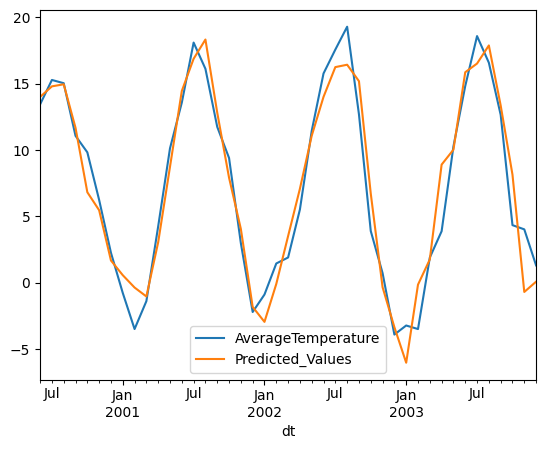

In [729]:
df_c = pd.concat([df_train_2,df_test])
df_c[['AverageTemperature','Predicted_Values']].plot()

In [ ]:
res

,Residuals
dt,
2000-02-01,-0.413327
2000-03-01,0.414048
2000-04-01,3.735091
2000-05-01,5.360757
2000-06-01,2.801935
2000-07-01,2.849144
2000-08-01,1.015382
2000-09-01,-2.739970
2000-10-01,-0.565784


In [745]:
def MA(q, res):
    """
    Perform Moving Average (MA) Time Series Analysis.

    This function applies Moving Average (MA) analysis to a time series of residuals from a previous
    model (e.g., Autoregressive, AR) to capture any remaining temporal patterns. It generates lagged
    features, splits the dataset into training and testing sets, applies linear regression to estimate
    coefficients for the MA model, and calculates the Root Mean Squared Error (RMSE) for model evaluation.

    Parameters:
    - q (int): The order of the Moving Average (MA) model, representing the number of lagged
      residuals to consider.
    - res (pandas DataFrame): The input DataFrame containing a 'Residuals' column from a previous
      model.

    Returns:
    - List: A list containing the following elements:
        1. res_train_2 (pandas DataFrame): Training dataset with lagged residuals and predictions.
        2. res_test (pandas DataFrame): Testing dataset with lagged residuals and predictions.
        3. coef (numpy array): Coefficients (weights) of the MA model.
        4. intercept (float): Intercept (bias) of the MA model.
        5. RMSE (float): Root Mean Squared Error of the MA model predictions.

    Notes:
    - The function calculates lagged residuals up to the order 'q' and uses them as features.
    - The dataset is split into training and testing sets, with an 80/20 split ratio.
    - Linear regression is applied to estimate MA model coefficients.
    - The RMSE is computed to evaluate model performance.

    Example:
    [res_train_2, res_test, coef, intercept, RMSE] = MA(3, df_residuals)
    print("The RMSE is:", RMSE)
    print("The order of the MA model is 3.")
    """
    # Generate lagged residuals as features
    for i in range(1, q + 1):
        res['Shifted_values_%d' % i] = res['Residuals'].shift(i)

    # Determine the size of the training set (80% of the data)
    train_size = (int)(0.8 * res.shape[0])

    # Split the data into training and testing sets
    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    # Remove rows with missing values in the training set
    res_train_2 = res_train.dropna()

    # Extract lagged residuals (X) and residuals (y) for training
    X_train = res_train_2.iloc[:, 1:].values.reshape(-1, q)
    y_train = res_train_2.iloc[:, 0].values.reshape(-1, 1)

    # Apply linear regression to estimate MA model coefficients
    result = ols_linear_regression(X_train, y_train)
    coef = result[0]
    intercept = result[1]

    # Generate predictions for the training set
    res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)

    # Prepare lagged residuals for the testing set
    X_test = res_test.iloc[:, 1:].values.reshape(-1, q)

    # Generate predictions for the testing set
    res_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef, intercept)

    # Calculate RMSE to evaluate model performance
    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    # Print RMSE and order of the MA model
    print("The RMSE is:", RMSE)
    print("The order of the MA model is", q)

    return [res_train_2, res_test, coef, intercept, RMSE]

In [746]:
[res_train_2,res_test,coef,intercept,RMSE] = MA(5,res)

The RMSE is: 3.1056218443251473
The order of the MA model is 5


C:\Users\gaute\AppData\Local\Temp\ipykernel_5912\3203892805.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)


In [735]:

res_c = pd.concat([res_train_2,res_test])

res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Predicted_Values
dt,,,,,,,
2000-11-01,0.772922,3.007656,-0.603843,0.082806,0.482838,-0.564772,-0.741083
2000-12-01,0.578937,0.772922,3.007656,-0.603843,0.082806,0.482838,-1.064728
2001-01-01,-1.338811,0.578937,0.772922,3.007656,-0.603843,0.082806,-1.414922
2001-02-01,-3.128475,-1.338811,0.578937,0.772922,3.007656,-0.603843,-1.263868
2001-03-01,-0.350814,-3.128475,-1.338811,0.578937,0.772922,3.007656,0.537826
2001-04-01,1.196923,-0.350814,-3.128475,-1.338811,0.578937,0.772922,1.446799
2001-05-01,1.390706,1.196923,-0.350814,-3.128475,-1.338811,0.578937,1.543757
2001-06-01,-0.877489,1.390706,1.196923,-0.350814,-3.128475,-1.338811,0.634635
2001-07-01,1.220266,-0.877489,1.390706,1.196923,-0.350814,-3.128475,-0.402038


<Axes: xlabel='dt'>

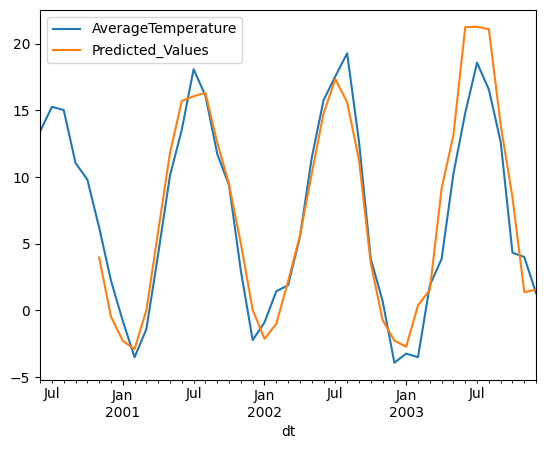

In [737]:
df_c.Predicted_Values += res_c.Predicted_Values
df_c[['AverageTemperature','Predicted_Values']].plot()

What about future values?

In [750]:
# Define the number of future periods you want to predict
n_periods = 12  # Adjust this as needed

# Extend the date range to include future dates
last_date = df_testing.index.max()  # Get the last date in your DataFrame
future_dates = pd.date_range(start=last_date, periods=n_periods+1, freq='M')  # Adjust frequency as needed
future_dates = future_dates[1:]  # Exclude the last date (it's already in your DataFrame)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates})

In [751]:
future_df

,Date
0,2004-01-31
1,2004-02-29
2,2004-03-31
3,2004-04-30
4,2004-05-31
5,2004-06-30
6,2004-07-31
7,2004-08-31
8,2004-09-30
9,2004-10-31


In [754]:
# Train the AR model (adjust p as needed)
#[p, df_train_2, df_test, coef_ar, intercept_ar, RMSE_ar, MSE_ar, res_ar] = AR(p, df_testing)
# Initialize a list to store future temperature predictions
n_periods = 12
p = 5
future_temperature_predictions = []

# Generate future predictions using the AR model
for _ in range(n_periods):
    # Calculate the lagged values for the AR model
    lagged_values = [future_df.iloc[-p - 1 - i]['Temperature'] for i in range(p)]
    
    # Predict the future temperature using the AR model
    future_temperature = coef_ar * np.array(lagged_values).sum() + intercept_ar
    
    # Append the prediction to the list
    future_temperature_predictions.append(future_temperature)
    
    # Update the future_df DataFrame with the predicted temperature
    future_df = future_df.append({'Date': future_df.iloc[-1]['Date'] + pd.DateOffset(months=1),
                                  'Temperature': future_temperature}, ignore_index=True)

# Convert the list of future predictions to a DataFrame
future_temperature_df = pd.DataFrame({'Date': future_dates, 'Temperature': future_temperature_predictions})

# Train the MA model on the residuals of the AR model (adjust q as needed)
[q, res_train_2, res_test, coef_ma, intercept_ma, RMSE_ma] = MA(q, res_ar)

# Generate future residuals using the MA model
future_residual_predictions = []

for _ in range(n_periods):
    # Calculate the lagged values for the MA model
    lagged_residuals = [future_residual_predictions[-i - 1] for i in range(q)]
    
    # Predict the future residual using the MA model
    future_residual = coef_ma * np.array(lagged_residuals).sum() + intercept_ma
    
    # Append the prediction to the list
    future_residual_predictions.append(future_residual)

# Combine the AR and MA predictions to obtain the final forecast for future data points
final_future_predictions = future_temperature_df['Temperature'] + future_residual_predictions

# Add the final forecasts to the future_df DataFrame
future_df['Forecast'] = final_future_predictions

# Now, future_df contains the forecasts for future dates

ValueError: Length of values (0) does not match length of index (12)